In [1]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

## Constants

In [2]:
# Taken from https://deepgraphlearning.github.io/project/wikidata5m
WIKIDATA5M_TRANSDUCTIVE_NUM_ENTITIES = 4_594_485

# Set Seaborn theme
sns.set_theme(style='darkgrid')

## Acquiring relevant metrics from dim32 embeddings

In [3]:
dim32_predicate_metrics = pd.read_csv('metrics/predicate_metrics.csv')

# Only consider realistic values, evaluated on both ends
dim32_predicate_metrics = dim32_predicate_metrics.query('Type == "realistic" and Side == "both"')

In [4]:
# Filter for selected metrics to compare on
selected_metrics = ['arithmetic_mean_rank', 'hits_at_5', 'hits_at_10']

dim32_predicate_metrics = dim32_predicate_metrics[dim32_predicate_metrics['Metric'].isin(selected_metrics)]
dim32_predicate_metrics

,Side,Type,Metric,Value,relation_id,relation_label,model
140,both,realistic,arithmetic_mean_rank,828467.750,1,P1001,complex
194,both,realistic,hits_at_5,0.000,1,P1001,complex
203,both,realistic,hits_at_10,0.000,1,P1001,complex
365,both,realistic,arithmetic_mean_rank,1950983.625,3,P101,complex
419,both,realistic,hits_at_5,0.000,3,P101,complex
...,...,...,...,...,...,...,...
188744,both,realistic,hits_at_5,0.500,813,P945,transe
188753,both,realistic,hits_at_10,0.500,813,P945,transe
188915,both,realistic,arithmetic_mean_rank,16547.375,815,P97,transe
188969,both,realistic,hits_at_5,0.250,815,P97,transe


## Acquiring relevant metrics from dim512 embeddings

In [5]:
dim512_distmult_metrics = pd.read_csv('embeddings/dim_512/distmult/predicate_metrics.csv')
dim512_simple_metrics = pd.read_csv('embeddings/dim_512/simple/predicate_metrics.csv')
dim512_transe_metrics = pd.read_csv('embeddings/dim_512/transe/predicate_metrics.csv')

dim512_predicate_metrics = pd.concat([dim512_distmult_metrics, dim512_simple_metrics, dim512_transe_metrics])
dim512_predicate_metrics = dim512_predicate_metrics.query('Type == "realistic" and Side == "both"')

In [6]:
# Filter for selected metrics
dim512_predicate_metrics = dim512_predicate_metrics[dim512_predicate_metrics['Metric'].isin(selected_metrics)]
dim512_predicate_metrics

,Side,Type,Metric,Value,relation_id,relation_label,model
86,both,realistic,arithmetic_mean_rank,381136.562500,0,P31,distmult
194,both,realistic,hits_at_5,0.373626,0,P31,distmult
203,both,realistic,hits_at_10,0.391209,0,P31,distmult
311,both,realistic,arithmetic_mean_rank,85242.468750,1,P1412,distmult
419,both,realistic,hits_at_5,0.382353,1,P1412,distmult
...,...,...,...,...,...,...,...
46994,both,realistic,hits_at_5,0.500000,469,P511,transe
47003,both,realistic,hits_at_10,0.500000,469,P511,transe
47174,both,realistic,arithmetic_mean_rank,76.000000,492,P832,transe
47219,both,realistic,hits_at_5,0.000000,492,P832,transe


## Utility Functions

In [7]:
def get_wikidata_property_names(property_ids: list):
    wikidata_api = 'https://www.wikidata.org/w/api.php'
    params = {
        'action': 'wbgetentities',
        'ids': '|'.join(property_ids),
        'languages': 'en',
        'props': 'labels',
        'format': 'json'
    }

    response = requests.get(wikidata_api, params).json()

    property_names = []
    for pid in property_ids:
        property_names.append(response['entities'][pid]['labels']['en']['value'])

    return property_names

## Metric Distributions over all predicates

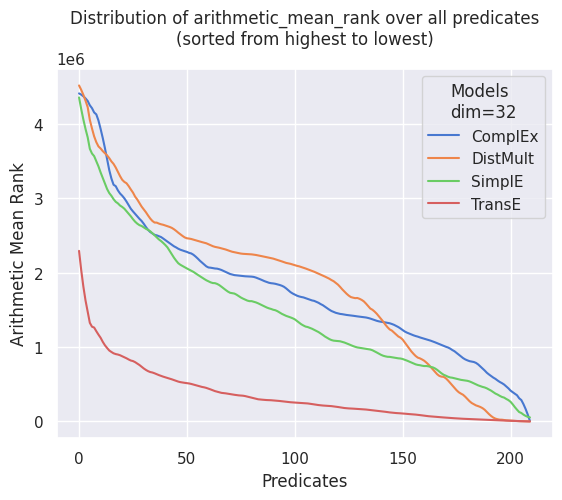

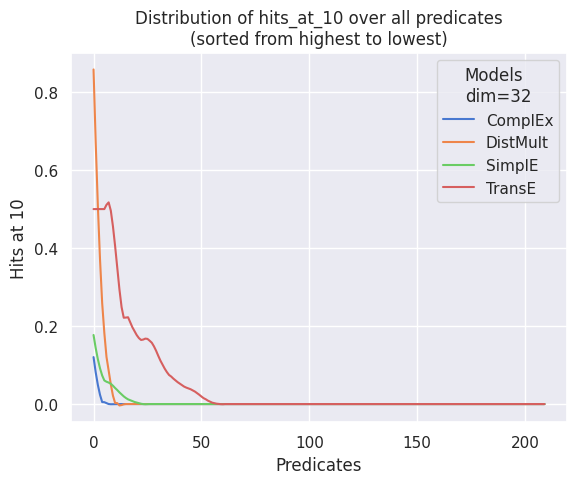

In [8]:
def compute_smooth_metrics_curve(metrics_df, window_size, polyorder):
    return metrics_df.assign(value_smooth=savgol_filter(metrics_df['Value'], window_size, polyorder))


def plot_predicate_metric_distributions(predicate_metrics, metric_name, embedding_dim=32, smoothen=True):
    metrics_df = predicate_metrics[predicate_metrics['Metric'] == metric_name]

    models_list = metrics_df['model'].sort_values().unique()
    model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']
    
    if 'complex' not in models_list:
        model_labels = ['DistMult', 'SimplE', 'TransE']
    
    metric_label = metric_name
    if metric_name == 'arithmetic_mean_rank':
        metric_label = 'Arithmetic Mean Rank'
    elif metric_name == 'hits_at_5':
        metric_label = 'Hits at 5'
    elif metric_name == 'hits_at_10':
        metric_label = 'Hits at 10'

    smoothen_window_size = 10
    smoothen_polyorder = 2

    indexed_metrics = []
    for model in models_list:
        model_metrics = metrics_df[metrics_df['model'] == model]
        model_metrics = model_metrics.sort_values(by='Value', ascending=False, ignore_index=True).reset_index()

        if smoothen:
            model_metrics = compute_smooth_metrics_curve(model_metrics, smoothen_window_size, smoothen_polyorder)

        indexed_metrics.append(model_metrics)

    indexed_metrics_df = pd.concat(indexed_metrics)

    g = sns.lineplot(x='index', y='value_smooth', hue='model', data=indexed_metrics_df, estimator='mean',
                     palette='muted')
    
    # Change legend labels and title to capitalized names
    legend = g.get_legend()
    legend.set_title(f'Models\ndim={embedding_dim}')
    for lt, label in zip(legend.texts, model_labels):
        lt.set_text(label)

    plt.title(f'Distribution of {metric_name} over all predicates\n(sorted from highest to lowest)')
    plt.xlabel('Predicates')
    plt.ylabel(metric_label)

    plt.show()


plot_predicate_metric_distributions(dim32_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=32)
plot_predicate_metric_distributions(dim32_predicate_metrics, 'hits_at_10', embedding_dim=32)

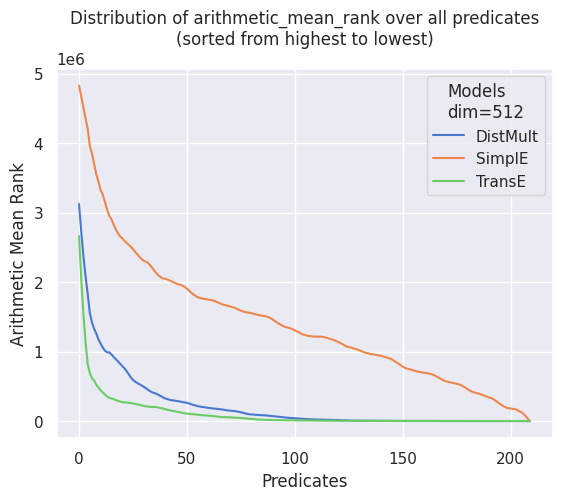

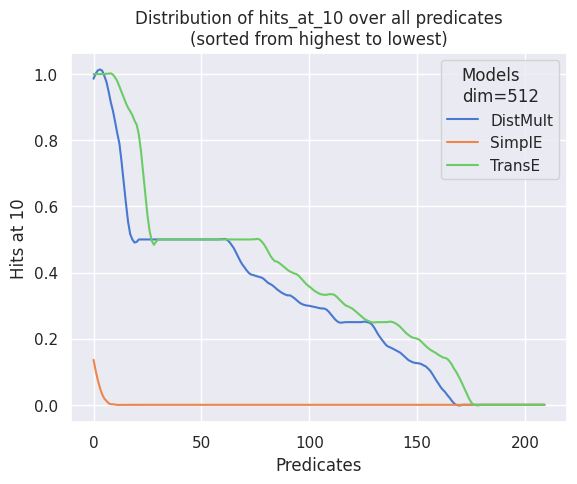

In [9]:
plot_predicate_metric_distributions(dim512_predicate_metrics, 'arithmetic_mean_rank', embedding_dim=512)
plot_predicate_metric_distributions(dim512_predicate_metrics, 'hits_at_10', embedding_dim=512)

## Selecting predicates with varying metrics per model 

In [10]:
def find_largest_metric_variances(predicate_metrics):
    predicates = predicate_metrics['relation_label'].unique()
    metric_names = predicate_metrics['Metric'].unique()
    model_names = predicate_metrics['model'].unique()

    metric_values = np.empty((len(predicates), len(metric_names), len(model_names)))

    for y, metric_name in enumerate(metric_names):
        for z, model_name in enumerate(model_names):
            metrics = predicate_metrics.query('Metric == @metric_name and model == @model_name')

            metric_values[:, y, z] = metrics['Value'].values

    metric_variances = np.var(metric_values, axis=2).mean(axis=1)

    variances_df = pd.DataFrame({
        'relation_label': predicates,
        'variance': metric_variances
    })

    return variances_df.sort_values(by='variance', ascending=False, ignore_index=True)


variances_df = find_largest_metric_variances(dim32_predicate_metrics)

# Limit to the highest 5 variances
variances_df = variances_df.head(5)

In [11]:
def filter_metrics(metrics_df, metric_name, filter_func):
    return metrics_df[metrics_df.apply(lambda x: x.Metric == metric_name and filter_func(x.Value), axis=1)]


hits10_nonzero = filter_metrics(dim32_predicate_metrics, 'hits_at_10', lambda value: value > 0)
hits10_nonzero.sort_values(by='Value', ascending=False)

,Side,Type,Metric,Value,relation_id,relation_label,model
81428,both,realistic,hits_at_10,1.000000,615,P460,distmult
174803,both,realistic,hits_at_10,0.500000,590,P4312,transe
84128,both,realistic,hits_at_10,0.500000,641,P516,distmult
152303,both,realistic,hits_at_10,0.500000,133,P1435,transe
188753,both,realistic,hits_at_10,0.500000,813,P945,transe
...,...,...,...,...,...,...,...
39578,both,realistic,hits_at_10,0.005495,695,P641,complex
182678,both,realistic,hits_at_10,0.005000,714,P69,transe
179303,both,realistic,hits_at_10,0.004926,656,P54,transe
26528,both,realistic,hits_at_10,0.003304,461,P31,complex


In [12]:
filter_metrics(dim32_predicate_metrics, 'hits_at_5', lambda value: value > 0).sort_values(by='Value', ascending=False)

,Side,Type,Metric,Value,relation_id,relation_label,model
81419,both,realistic,hits_at_5,1.000000,615,P460,distmult
188744,both,realistic,hits_at_5,0.500000,813,P945,transe
186944,both,realistic,hits_at_5,0.500000,779,P859,transe
174794,both,realistic,hits_at_5,0.500000,590,P4312,transe
152294,both,realistic,hits_at_5,0.500000,133,P1435,transe
...,...,...,...,...,...,...,...
136769,both,realistic,hits_at_5,0.004762,726,P735,simple
184019,both,realistic,hits_at_5,0.002381,726,P735,transe
148019,both,realistic,hits_at_5,0.002212,83,P131,transe
100769,both,realistic,hits_at_5,0.002212,83,P131,simple


In [13]:
def select_duplicate_values(df, column):
    groups = df.groupby(by=column).size().sort_values(ascending=False)
    return pd.concat([df[df[column] == value] for value in groups[groups > 1].index.values])


select_duplicate_values(hits10_nonzero, 'relation_label')

,Side,Type,Metric,Value,relation_id,relation_label,model
26528,both,realistic,hits_at_10,0.003304,461,P31,complex
121028,both,realistic,hits_at_10,0.044604,461,P31,simple
168278,both,realistic,hits_at_10,0.042401,461,P31,transe
2228,both,realistic,hits_at_10,0.020677,27,P106,complex
96728,both,realistic,hits_at_10,0.056391,27,P106,simple
143978,both,realistic,hits_at_10,0.054511,27,P106,transe
32378,both,realistic,hits_at_10,0.037037,574,P413,complex
126878,both,realistic,hits_at_10,0.138889,574,P413,simple
174128,both,realistic,hits_at_10,0.212963,574,P413,transe
32828,both,realistic,hits_at_10,0.021053,584,P421,complex


In [14]:
example_predicates = ['P31', 'P106', 'P413', 'P421', 'P641', 'P47', 'P1344', 'P364']
get_wikidata_property_names(example_predicates)

['instance of',
 'occupation',
 'position played on team / speciality',
 'located in time zone',
 'sport',
 'shares border with',
 'participant in',
 'original language of film or TV show']

## Metric Comparison on selected predicates

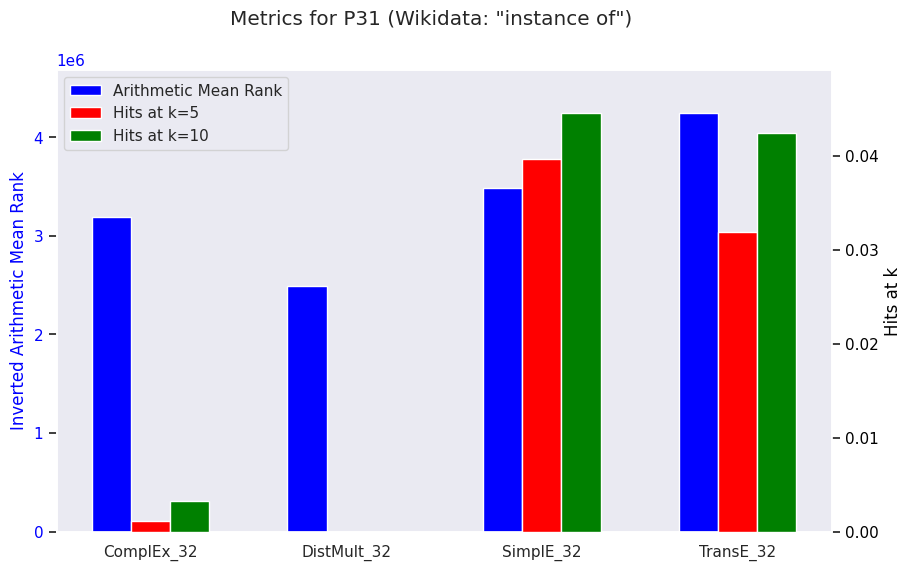

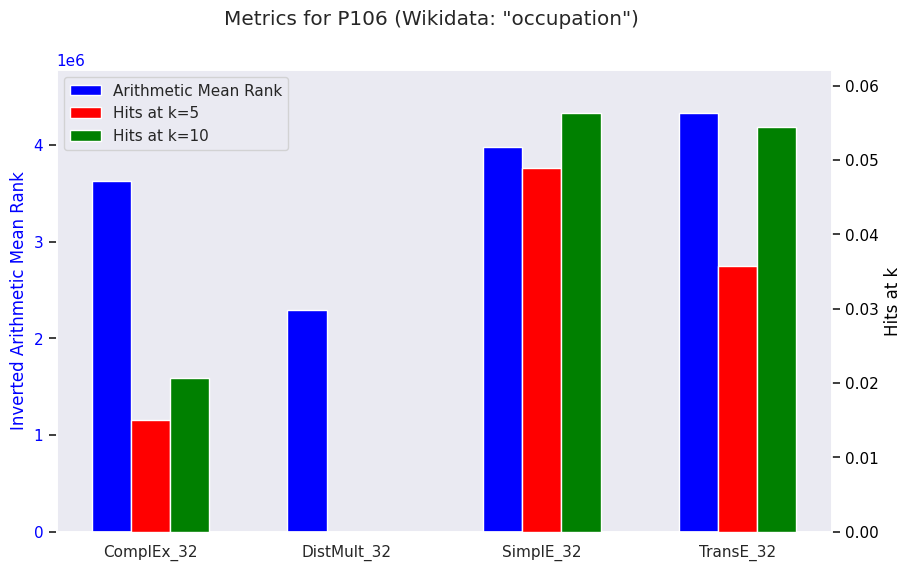

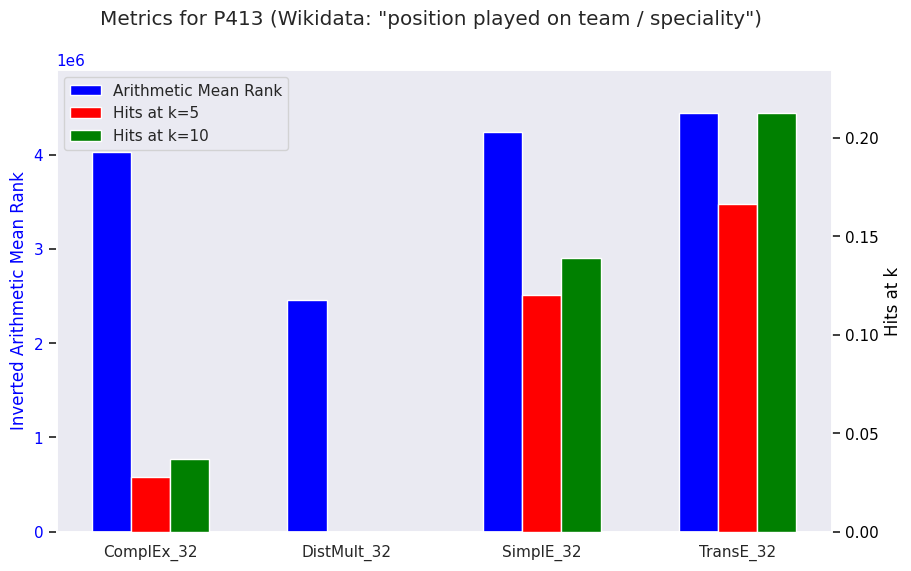

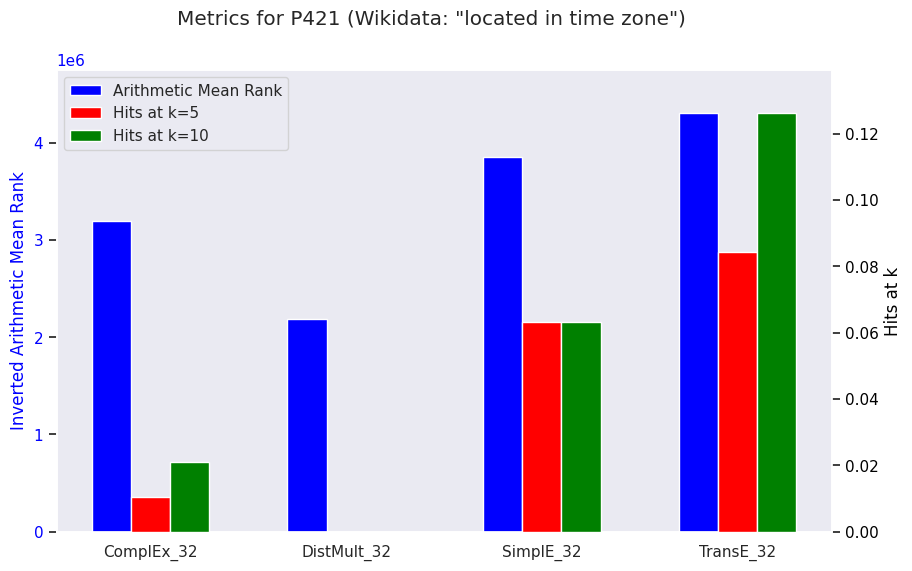

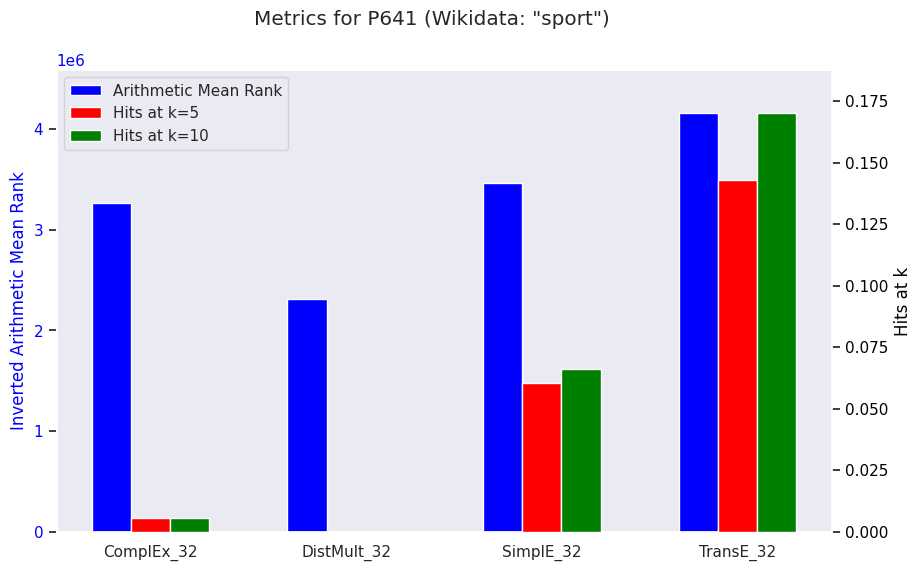

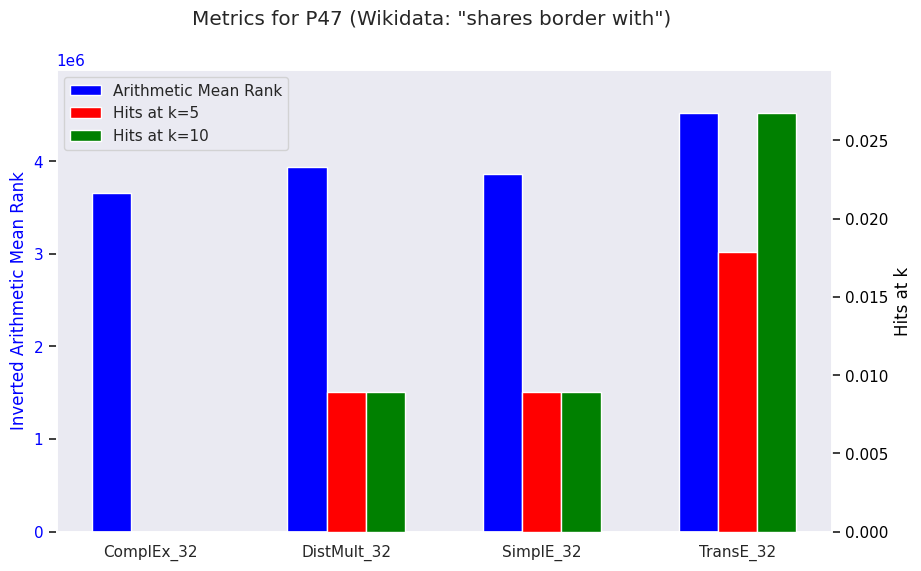

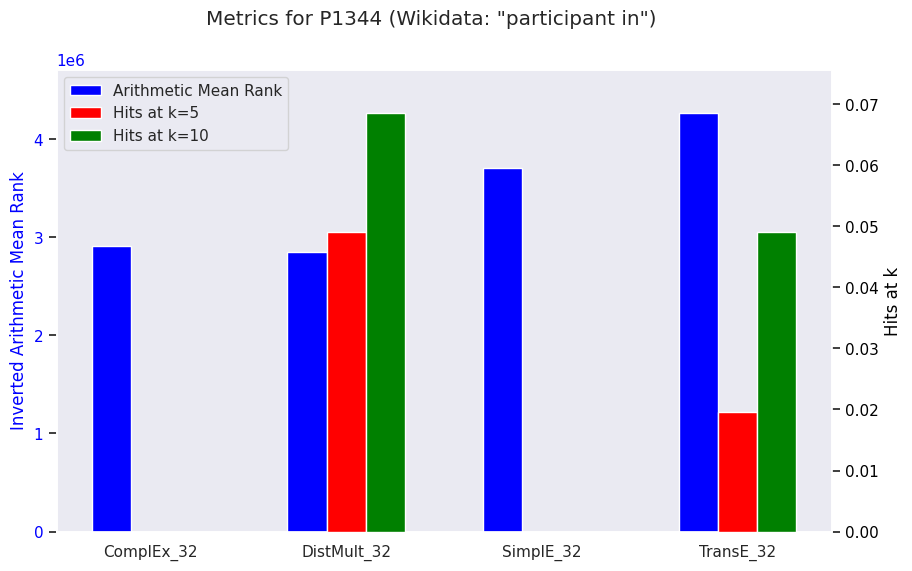

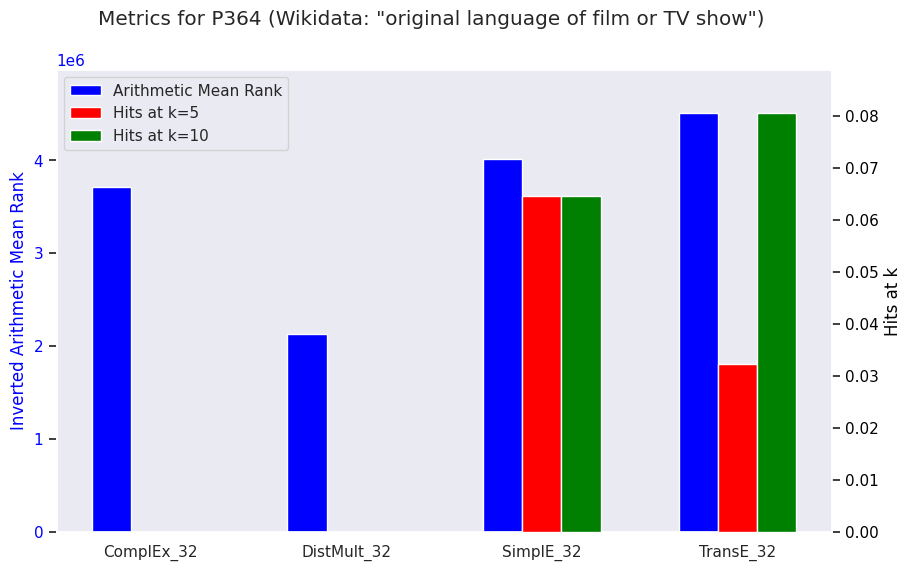

In [15]:
def plot_selected_predicate_metrics_grouped(predicate_metrics, predicate_list, embedding_dim=32, ylim_extend=1):
    wikidata_labels = get_wikidata_property_names(predicate_list)

    for pred, w_label in zip(predicate_list, wikidata_labels):
        pred_df = predicate_metrics[predicate_metrics['relation_label'] == pred]

        # Sort by metric name to ensure correct ordering
        pred_df = pred_df.sort_values(by=['Metric', 'model'])

        # Filter values for each metric
        amr_values = pred_df[pred_df['Metric'] == 'arithmetic_mean_rank']
        hits5_values = pred_df[pred_df['Metric'] == 'hits_at_5']
        hits10_values = pred_df[pred_df['Metric'] == 'hits_at_10']
        
        # Invert arithmetic mean rank to have bigger values be better and
        # to comply with the hits at k axis (easier readability of the plot)
        # Hint: Add +1 to num_entities because PyKEEN ranks are 1-based
        inv_amr_values = (WIKIDATA5M_TRANSDUCTIVE_NUM_ENTITIES + 1) - amr_values['Value'].values

        # Create figure and axes
        fig, ax1 = plt.subplots(figsize=(10, 6))
        fig.suptitle(f'Metrics for {pred} (Wikidata: "{w_label}")')
        colors = ['blue', 'red', 'green']
        model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']
        
        if 'complex' not in pred_df['model'].unique():
            model_labels = ['DistMult', 'SimplE', 'TransE']
            
        model_labels = [f'{model}_{embedding_dim}' for model in model_labels]

        # Set bar width and positions
        bar_width = 0.2
        x_pos = np.arange(len(amr_values['model']))
        bar1_pos = x_pos - bar_width
        bar2_pos = x_pos
        bar3_pos = x_pos + bar_width

        # Plot Arithmetic Mean Rank on the left y-axis
        ax1.bar(bar1_pos, inv_amr_values, color=colors[0], width=bar_width, label='Arithmetic Mean Rank', zorder=3)
        ax1.set_ylabel('Inverted Arithmetic Mean Rank', color=colors[0])
        ax1.tick_params(axis='y', labelcolor=colors[0], zorder=0)
        ax1.grid(False)
        ax1.set_xticks(bar2_pos)
        ax1.set_xticklabels(model_labels)

        # Create a second y-axis for Hits at 5 and 10
        ax2 = ax1.twinx()
        ax2.bar(bar2_pos, hits5_values['Value'], color=colors[1], width=bar_width, label='Hits at k=5', zorder=3)
        ax2.bar(bar3_pos, hits10_values['Value'], color=colors[2], width=bar_width, label='Hits at k=10', zorder=3)
        ax2.set_ylabel('Hits at k', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.grid(False)
        
        # Extend the y-axis to the top to create space for the legend,
        # without overlapping the bars
        ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * ylim_extend)
        ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1] * ylim_extend)

        # Combine legends for both axes
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        # Set x-axis label
        plt.xlabel('Model')
        # plt.savefig()

        # Show plot
        plt.show()


plot_selected_predicate_metrics_grouped(dim32_predicate_metrics, example_predicates, embedding_dim=32, ylim_extend=1.05)

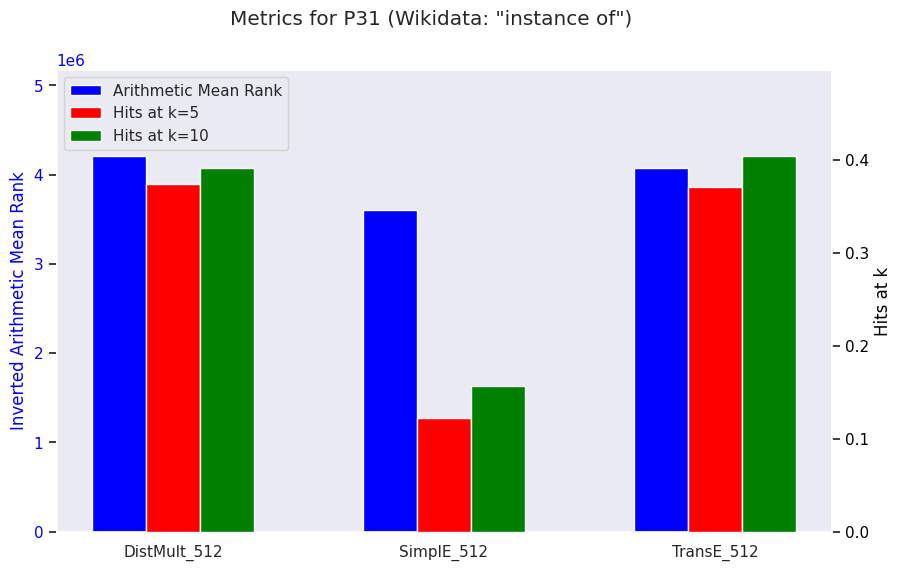

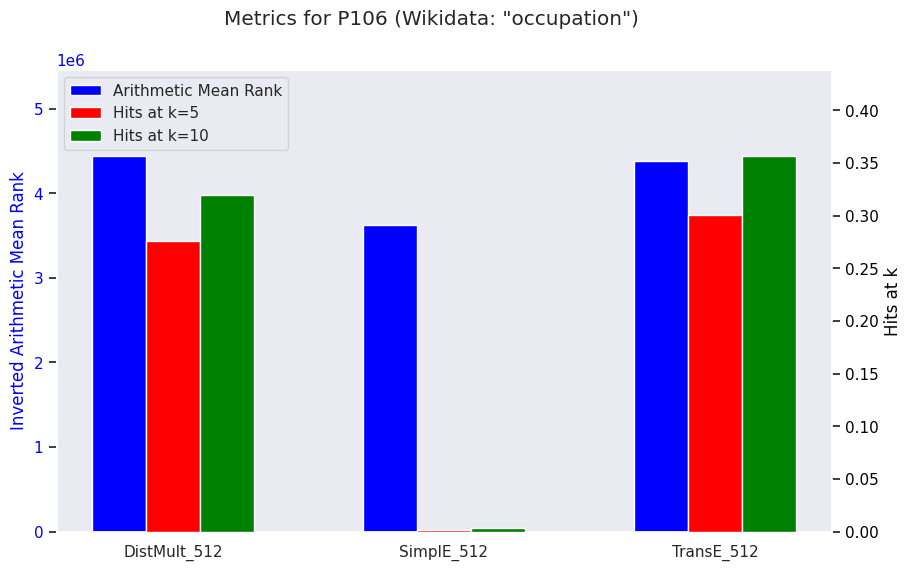

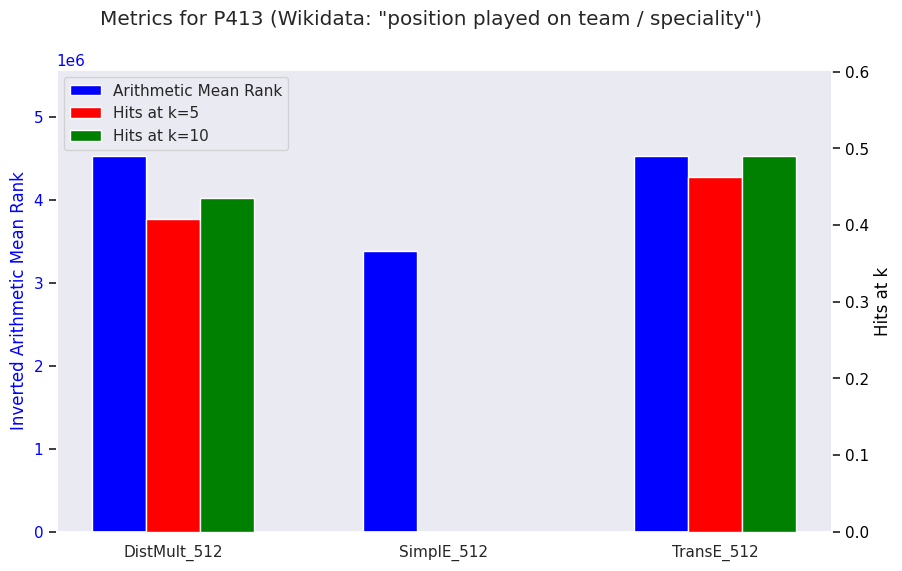

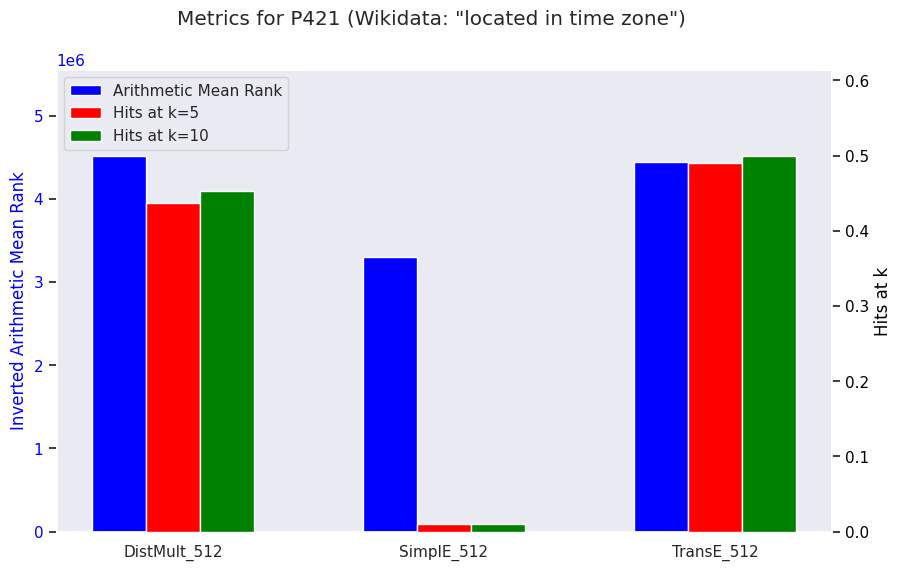

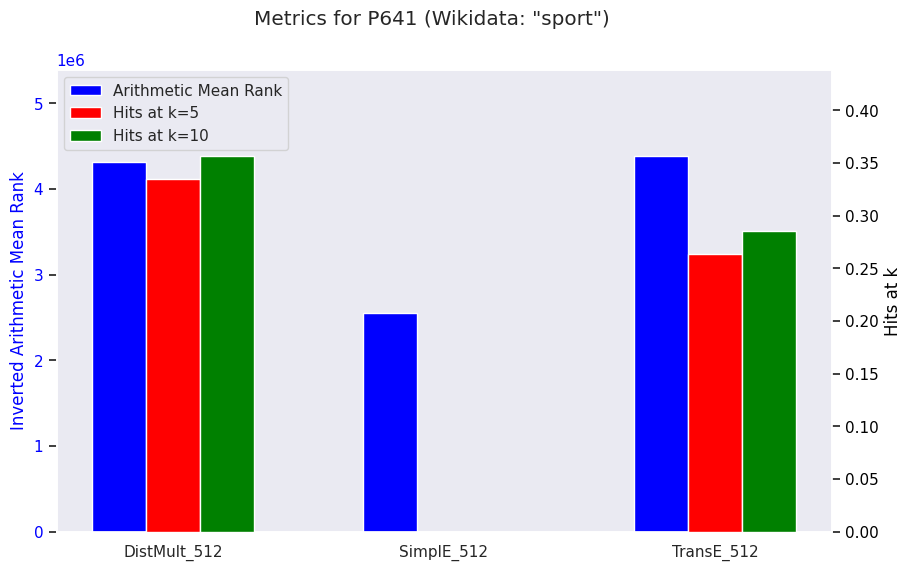

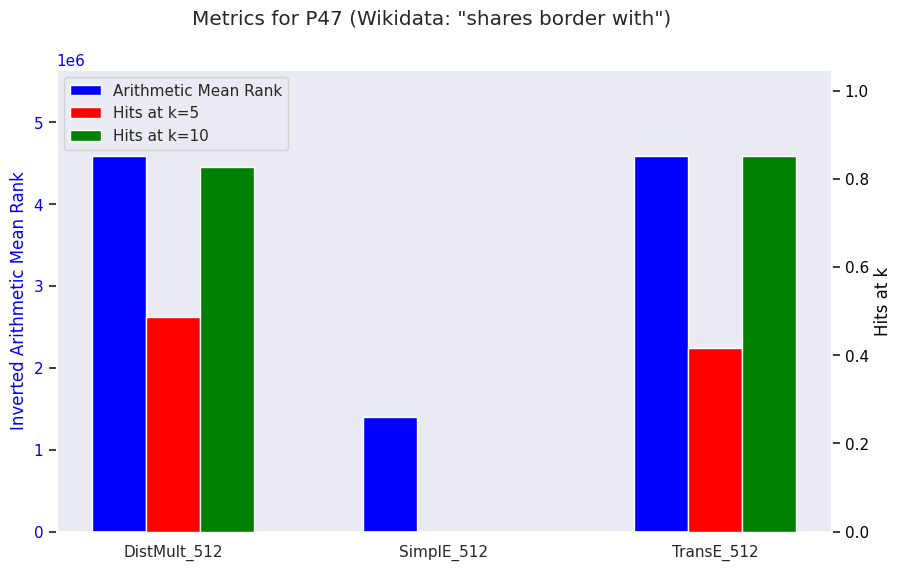

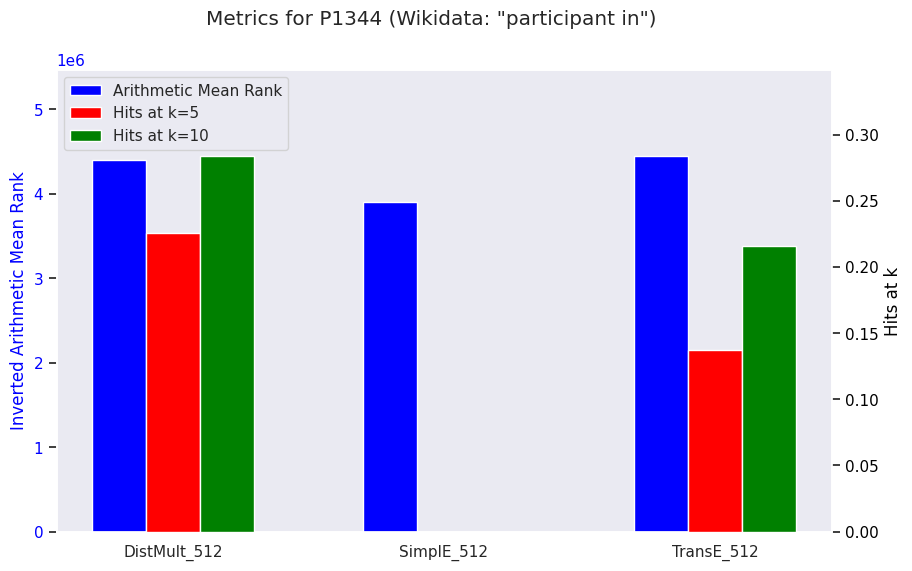

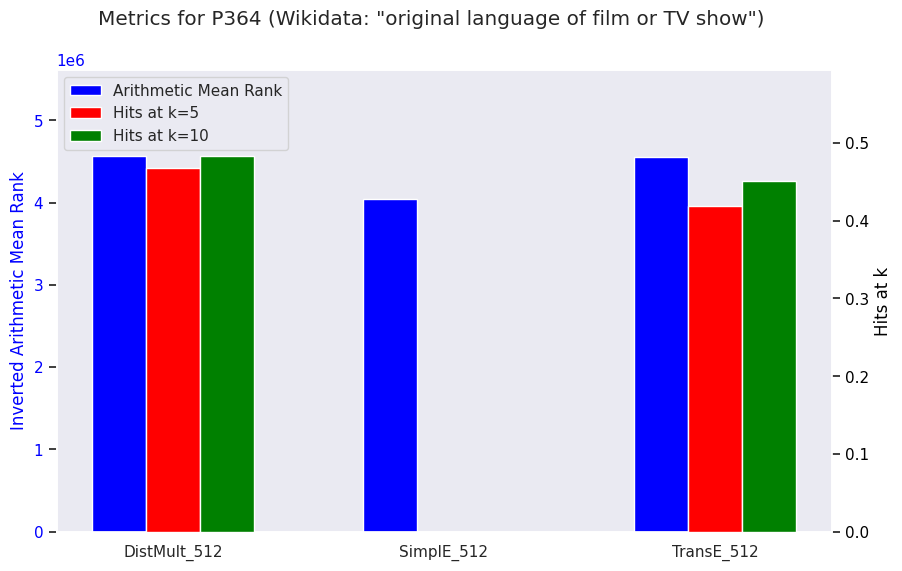

In [16]:
plot_selected_predicate_metrics_grouped(dim512_predicate_metrics, example_predicates, embedding_dim=512, ylim_extend=1.17)